# Lab | Random Forests
For this lab, you will be using the .CSV files provided in the files_for_lab folder. These are cleaned versions of the learningSet data from the Case Study 'Healthcare for All'.
Begin a new Jupyter Notebook after Forking and Cloning this Repo.

#### Instructions
- Apply the Random Forests algorithm but this time only by upscaling the data to deal with the imbalance.
- Use Feature Selections that you have learned in class to decide if you want to use all of the features (Variance Threshold, RFE, PCA, etc.)
- Re-run the Random Forest algorithm to determine if the Feature Selection has improved the results.
- Discuss the output and its impact in the business scenario. Is the cost of a false positive equals to the cost of the false negative? How would you change your algorithm or data in order to maximize the return of the business?

## Import Libraries

In [1]:
import sklearn
print(sklearn.__version__)

# I tried to import plot_confusion_matrix but I finally couldn't with any version of sklearn

1.3.2


In [40]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold, RFE

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import sys
np.set_printoptions(threshold=sys.maxsize)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix

## Load and Combine the data

In [4]:
# Load the data
categorical = pd.read_csv('categorical.csv')
numerical = pd.read_csv('numerical.csv')
target = pd.read_csv('target.csv')

# Combine all the data into a single DataFrame
data = pd.concat([numerical, categorical, target], axis=1)

## Check the data

In [5]:
data.head()

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,...,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM,TARGET_B,TARGET_D
0,0,60.000000,5,9,0,0,39,34,18,10,...,92,8,94,2,95,12,89,11,0,0.0
1,1,46.000000,6,9,16,0,15,55,11,6,...,93,10,95,12,95,12,93,10,0,0.0
2,1,61.611649,3,1,2,0,20,29,33,6,...,91,11,92,7,95,12,90,1,0,0.0
3,0,70.000000,1,4,2,0,23,14,31,3,...,87,11,94,11,95,12,87,2,0,0.0
4,0,78.000000,3,2,60,1,28,9,53,26,...,93,10,96,1,96,1,79,3,0,0.0


In [6]:
data.shape

(95412, 339)

In [7]:
# Check nulls
data.isna().sum().sum()

0

Data is already cleaned so I can start the lab without checking more.

## Prepare the data

### Split features and target

In [8]:
# Define the feature set (X) and the target variable (y)
X = data.drop(['TARGET_B','TARGET_D'],axis=1)
y = data['TARGET_B']

# Variable for TARGET_D
target_d = target['TARGET_D']
target_d.value_counts()

# Display targets B and D
target

,TARGET_B,TARGET_D
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
...,...,...
95407,0,0.0
95408,0,0.0
95409,0,0.0
95410,1,18.0


In [9]:
# Identify numerical and categorical feature columns
X_num = X.select_dtypes(np.number)
X_cat = X.select_dtypes(object)

### Encoding categorical features

In [13]:
# One-hot encode categorical variables
encoder = OneHotEncoder(drop='first').fit(X_cat)

# Use the encoder to transform the categorical data in X_cat into a sparse matrix
X_encoded_cat = encoder.transform(X_cat).toarray()

# Create a DataFrame from the sparse matrix with column names obtained from the encoder
X_encoded_cat = pd.DataFrame(X_encoded_cat, columns=encoder.get_feature_names_out())

# Reset the index dropping the previous index
X_encoded_cat.reset_index(drop=True, inplace=True)

In [14]:
X_encoded_cat.head()

,STATE_FL,STATE_GA,STATE_IL,STATE_IN,STATE_MI,STATE_MO,STATE_NC,STATE_TX,STATE_WA,STATE_WI,...,RFA_2A_E,RFA_2A_F,RFA_2A_G,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D,DOMAIN_A_R,DOMAIN_A_S,DOMAIN_A_T,DOMAIN_A_U
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Scaling numerical features

In [15]:
# Create an instance of the MinMaxScaler and fit it to the numerical data in X_num
transformer = MinMaxScaler().fit(X_num)

# Transform (scale) the numerical data in X_num using the fitted scaler
X_num_norm = transformer.transform(X_num)

# Create a DataFrame from the scaled data with the same index and columns as X_num
X_num_scale = pd.DataFrame(X_num_norm, index=X_num.index, columns=X_num.columns)

# Reset the index of X_num_scale, dropping the previous index
X_num_scale.reset_index(drop=True, inplace=True)

In [16]:
X_num_norm.shape

(95412, 330)

In [17]:
X_num_scale.head()

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,...,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM
0,0.000000,0.608247,0.666667,1.000000,0.000000,0.000000,0.393939,0.343434,0.181818,0.101010,...,0.381443,1.000000,0.772727,0.636364,0.863636,0.090909,0.0,1.0,0.927083,0.909091
1,0.000014,0.463918,0.833333,1.000000,0.066390,0.000000,0.151515,0.555556,0.111111,0.060606,...,0.536082,0.090909,0.818182,0.818182,0.909091,1.000000,0.0,1.0,0.968750,0.818182
2,0.000014,0.624862,0.333333,0.111111,0.008299,0.000000,0.202020,0.292929,0.333333,0.060606,...,0.000000,0.090909,0.727273,0.909091,0.772727,0.545455,0.0,1.0,0.937500,0.000000
3,0.000000,0.711340,0.000000,0.444444,0.008299,0.000000,0.232323,0.141414,0.313131,0.030303,...,0.288660,0.000000,0.545455,0.909091,0.863636,0.909091,0.0,1.0,0.906250,0.090909
4,0.000000,0.793814,0.333333,0.222222,0.248963,0.010101,0.282828,0.090909,0.535354,0.262626,...,0.206186,0.000000,0.818182,0.818182,0.954545,0.000000,0.5,0.0,0.822917,0.181818


### Concat scaled and encoded features

In [18]:
# Concat scaled numerical and encoded categorical features
X = pd.concat([X_num_scale, X_encoded_cat], axis = 1)

In [19]:
X.head()

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,...,RFA_2A_E,RFA_2A_F,RFA_2A_G,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D,DOMAIN_A_R,DOMAIN_A_S,DOMAIN_A_T,DOMAIN_A_U
0,0.000000,0.608247,0.666667,1.000000,0.000000,0.000000,0.393939,0.343434,0.181818,0.101010,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.000014,0.463918,0.833333,1.000000,0.066390,0.000000,0.151515,0.555556,0.111111,0.060606,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.000014,0.624862,0.333333,0.111111,0.008299,0.000000,0.202020,0.292929,0.333333,0.060606,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.000000,0.711340,0.000000,0.444444,0.008299,0.000000,0.232323,0.141414,0.313131,0.030303,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.000000,0.793814,0.333333,0.222222,0.248963,0.010101,0.282828,0.090909,0.535354,0.262626,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Check the target

0    90569
1     4843
Name: TARGET_B, dtype: int64


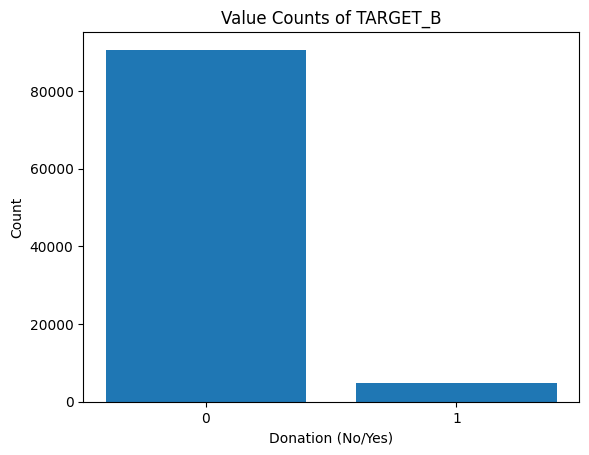

In [20]:
import matplotlib.pyplot as plt

value_counts = data['TARGET_B'].value_counts()

# Print the value counts
print(value_counts)

# Plot the value counts
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Donation (No/Yes)')
plt.ylabel('Count')
plt.title('Value Counts of TARGET_B')

# Set x-tick labels to "0" and "1"
plt.xticks(value_counts.index, ["0", "1"])

plt.show()

- We see imbalanced data
- Therefore, we will use SMOTE technique to work on the imbalanced data

### Split the data into train and test sets

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Upscaling the data - SMOTE

In [22]:
# Initialize SMOTE, an oversampling method to balance the dataset
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

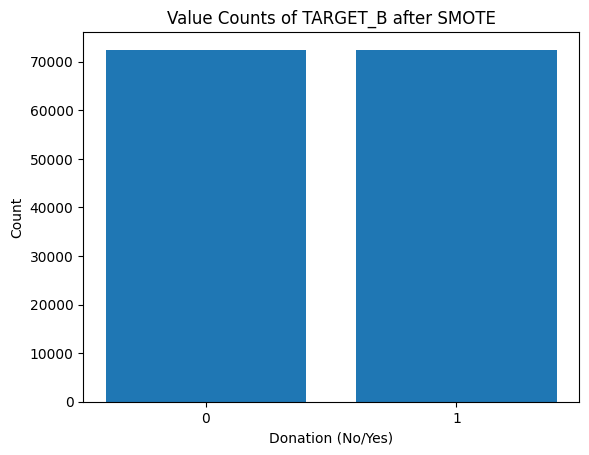

In [23]:
# value_counts to count the occurrences of each class
value_counts_smote = y_train_smote.value_counts()

# Plot the value counts after applying SMOTE
plt.bar(value_counts_smote.index, value_counts_smote.values)
plt.xlabel('Donation (No/Yes)')
plt.ylabel('Count')
plt.title('Value Counts of TARGET_B after SMOTE')

# Set x-tick labels to "0" and "1"
plt.xticks(value_counts_smote.index, ["0", "1"])

plt.show()

## Random Forest only by upscaling the data

In [24]:
rf = RandomForestClassifier(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf =20)
rf.fit(X_train_smote, y_train_smote)
print(rf.score(X_train_smote, y_train_smote))
print(rf.score(X_test, y_test))

0.8720675093839699
0.8290101137137766


In [29]:
# takes too long to check on this one

rf = RandomForestClassifier(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf =20)
cross_val_scores = cross_val_score(rf, X_train_smote, y_train_smote, cv=10)
print(np.mean(cross_val_scores))
print(cross_val_scores)

0.872509325649496
[0.70033809 0.89298282 0.89450079 0.89670876 0.89470779 0.88891189
 0.89726075 0.88311599 0.88835219 0.88821419]


In [30]:
# takes too long to check on this one also

rf = RandomForestClassifier(max_depth=10,
                             min_samples_split=20,
                             min_samples_leaf =20).fit(X_train_smote, y_train_smote)

y_pred = rf.predict(X_test)

print('accuracy:', accuracy_score(y_test, y_pred))
print("precision: ",precision_score(y_test, y_pred))
print("recall: ",recall_score(y_test, y_pred))
print("f1: ",f1_score(y_test, y_pred))

accuracy: 0.9189330818005554
precision:  0.08708272859216255
recall:  0.06134969325153374
f1:  0.07198560287942413


1. **First Random Forest Model**:
   - We instantiate a `RandomForestClassifier` with a maximum depth of 5, minimum samples to split of 20, and minimum samples per leaf of 20.
   - We fit the model to our training data that has been oversampled with SMOTE (`X_train_smote`, `y_train_smote`).
   - We then print the score of the classifier on the training set and the test set.
   - The output scores (`0.8720675093839699` for the training set and `0.829011137137776` for the test set) are the accuracy of the model, which is the proportion of correctly predicted observations to the total observations. The model seems to perform reasonably well, but there is some overfitting since the training score is higher than the test score.

2. **Cross-Validation on Random Forest**:
   - We instantiate the same `RandomForestClassifier` as before.
   - Instead of fitting the model directly to the entire training set, we use `cross_val_score` to perform cross-validation. This method splits the data into 'k' folds (10 in our case), trains the model on 'k-1' folds, and tests it on the remaining fold. This process is repeated 'k' times, with each fold being used as the test set once.
   - The cross-validation scores are printed, giving an array of accuracy scores for each fold.
   - The mean cross-validation score (`0.872509325649496`) is also printed, providing an estimate of the model's accuracy from the cross-validation process.
   - Cross-validation is a more robust method for estimating the model's performance because it reduces the variance associated with a single trial of train-test split.

3. **Second Random Forest Model**:
   - A `RandomForestClassifier` is instantiated with a higher maximum depth of 10 (allowing the trees to grow deeper).
   - We fit this model to the SMOTE oversampled data and then make predictions on the test set.
   - The accuracy, precision, recall, and F1 score for the test set predictions are printed.
      - `Accuracy` (0.9189330818005554) is the proportion of true results among the total number of cases examined.
      - `Precision` (0.08708272859216255) measures the proportion of positive identifications that were actually correct.
      - `Recall` (0.01634969325153374) measures the proportion of actual positives that were identified correctly.
      - `F1 score` (0.07918560287942413) is the harmonic mean of precision and recall, and it is a measure of the model's accuracy considering both the precision and the recall.

The outputs indicate that while the model has a high accuracy, the precision and recall are very low, especially recall. This suggests that while the model is good at predicting the majority class, it struggles to correctly identify the minority class. This is often a challenge with imbalanced datasets, even after techniques like SMOTE are applied. The F1 score is also low, reflecting the poor performance in terms of precision and recall. This might be due to the classifier biasing towards the majority class or not being able to generalize well from the oversampled data for predictions on the test set.

## Feature Selection

### Numerical features

### Variance Threshold

In [58]:
# X_num_scale is my numerical data before applying SMOTE

# Split X_num_scale into training and testing sets
X_num_scale_train, X_num_scale_test = train_test_split(X_num_scale, test_size=0.2, random_state=42)

X_num_scale_train.head()

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,...,DOB_YR,DOB_MM,MINRDATE_YR,MINRDATE_MM,MAXRDATE_YR,MAXRDATE_MM,LASTDATE_YR,LASTDATE_MM,FIRSTDATE_YR,FIRSTDATE_MM
85225,0.000389,0.624862,0.666667,1.000000,0.000000,0.0,0.292929,0.363636,0.212121,0.070707,...,0.000000,0.090909,0.954545,0.090909,0.954545,0.090909,0.5,0.090909,1.000000,0.090909
70004,0.000000,0.649485,0.500000,1.000000,0.000000,0.0,0.232323,0.232323,0.282828,0.020202,...,0.350515,0.000000,0.681818,1.000000,0.772727,0.909091,0.0,0.727273,0.937500,0.818182
88133,0.000014,0.639175,1.000000,0.666667,0.008299,0.0,0.252525,0.272727,0.333333,0.030303,...,0.360825,0.000000,0.772727,0.000000,0.954545,0.000000,0.5,0.000000,0.916667,0.727273
79106,0.000028,0.731959,0.166667,1.000000,0.000000,0.0,0.343434,0.191919,0.303030,0.070707,...,0.268041,0.000000,0.863636,0.000000,0.863636,0.909091,0.0,0.454545,0.916667,0.636364
35476,0.000000,0.624862,0.000000,1.000000,0.000000,0.0,0.373737,0.464646,0.383838,0.060606,...,0.000000,0.090909,0.636364,0.818182,0.909091,1.000000,0.0,1.000000,0.927083,0.818182


In [59]:
X_num_scale_train.shape

(76329, 330)

I apply `VarianceThreshold` to the numerical subset of the training data prior to upsampling with SMOTE for a couple of reasons:

1. **Feature Relevance**: Variance is a measure of the spread of a feature's values. By selecting features with a higher variance, we focus on those that have a greater potential to be informative and discriminative in predicting the target variable.

2. **Data Integrity**: It's important to perform feature selection before upsampling because SMOTE creates synthetic samples based on the existing data distribution. By first eliminating low-variance features, we ensure that the upsampling process only amplifies the most relevant features, preventing the introduction of noise or irrelevant variations.

3. **Model Efficiency**: Reducing the number of features through variance thresholding can also improve the efficiency of the subsequent upsampling process and the training of the model by eliminating features that are unlikely to contribute to the model's predictive power.

4. Applying VarianceThreshold only to numerical features ensures that it measures meaningful variance in data, as categorical features have different characteristics.

In [61]:
numerical_features = X_num_scale_train.columns

In [62]:
# Define the VarianceThreshold with a threshold of 0.02
selector = VarianceThreshold(threshold=0.02)

# Fit the selector to the numerical features of X_train
selector.fit(X_num_scale_train)

# Transform the dataset to reduce to the selected features
X_train_numerical_reduced = selector.transform(X_num_scale_train)

# Get the boolean mask indicating which features are retained
features_mask = selector.get_support()

# Keep the feature names for the features that are retained
retained_features = numerical_features[features_mask]

# Create a DataFrame with the retained features
X_train_numerical_reduced = pd.DataFrame(X_train_numerical_reduced, 
                                            columns=retained_features)

In [63]:
X_train_numerical_reduced.shape

(76329, 90)

It seems that we have deleted 240 (330-90) numerical features. We retained 90.

In [64]:
# Check which ones are removed and which ones are retained

# Mask of features that are retained
retained_features_mask = selector.get_support()

# List of features that have been retained
retained_features = numerical_features[retained_features_mask].tolist()

# List of features that have been removed
removed_features = numerical_features[~retained_features_mask].tolist()

In [65]:
print("Retained features:", retained_features)

Retained features: ['AGE', 'INCOME', 'WEALTH1', 'VIETVETS', 'WWIIVETS', 'WEALTH2', 'POP90C1', 'POP90C2', 'POP90C3', 'ETH1', 'ETH2', 'HHN3', 'DW1', 'DW2', 'DW4', 'DW5', 'DW6', 'HV1', 'HV2', 'HV3', 'HV4', 'HU1', 'HU2', 'HU5', 'HHD2', 'HHD3', 'HHD5', 'ETHC2', 'HVP1', 'HVP2', 'HVP3', 'HVP4', 'HVP5', 'HVP6', 'HUR2', 'HUPA2', 'HUPA3', 'HUPA6', 'RP1', 'RP2', 'RP3', 'RP4', 'MSA', 'ADI', 'IC6', 'HHAS3', 'MC1', 'MC2', 'PEC2', 'TPE13', 'LFC2', 'LFC4', 'LFC6', 'LFC7', 'LFC8', 'LFC9', 'VC1', 'VC3', 'POBC2', 'LSC1', 'VOC2', 'HC2', 'HC4', 'HC5', 'HC6', 'HC7', 'HC8', 'HC11', 'HC13', 'HC17', 'HC18', 'HC19', 'MHUC1', 'MHUC2', 'CARDPROM', 'CONTROLN', 'HPHONE_D', 'RFA_2F', 'CLUSTER2', 'CLUSTER', 'DATASRCE', 'DOMAIN_B', 'ODATEW_YR', 'DOB_YR', 'DOB_MM', 'MINRDATE_MM', 'MAXRDATE_MM', 'LASTDATE_YR', 'LASTDATE_MM', 'FIRSTDATE_MM']


In [67]:
len(retained_features)

90

In [66]:
print("Removed features:", removed_features)

Removed features: ['TCODE', 'HIT', 'MALEMILI', 'MALEVET', 'LOCALGOV', 'STATEGOV', 'FEDGOV', 'POP901', 'POP902', 'POP903', 'POP90C4', 'POP90C5', 'ETH3', 'ETH4', 'ETH5', 'ETH6', 'ETH7', 'ETH8', 'ETH9', 'ETH10', 'ETH11', 'ETH12', 'ETH13', 'ETH14', 'ETH15', 'ETH16', 'AGE901', 'AGE902', 'AGE903', 'AGE904', 'AGE905', 'AGE906', 'AGE907', 'CHIL1', 'CHIL2', 'CHIL3', 'AGEC1', 'AGEC2', 'AGEC3', 'AGEC4', 'AGEC5', 'AGEC6', 'AGEC7', 'CHILC1', 'CHILC2', 'CHILC3', 'CHILC4', 'CHILC5', 'HHAGE1', 'HHAGE2', 'HHAGE3', 'HHN1', 'HHN2', 'HHN4', 'HHN5', 'HHN6', 'MARR1', 'MARR2', 'MARR3', 'MARR4', 'HHP1', 'HHP2', 'DW3', 'DW7', 'DW8', 'DW9', 'HU3', 'HU4', 'HHD1', 'HHD4', 'HHD6', 'HHD7', 'HHD8', 'HHD9', 'HHD10', 'HHD11', 'HHD12', 'ETHC1', 'ETHC3', 'ETHC4', 'ETHC5', 'ETHC6', 'HUR1', 'RHP1', 'RHP2', 'RHP3', 'RHP4', 'HUPA1', 'HUPA4', 'HUPA5', 'HUPA7', 'DMA', 'IC1', 'IC2', 'IC3', 'IC4', 'IC5', 'IC7', 'IC8', 'IC9', 'IC10', 'IC11', 'IC12', 'IC13', 'IC14', 'IC15', 'IC16', 'IC17', 'IC18', 'IC19', 'IC20', 'IC21', 'IC22', 

In [68]:
len(removed_features)

240

In the **retained_features list**, we have the names of all the numerical features that have a variance above the specified threshold (0.02) and are thus kept for the model. 

Conversely, the **removed_features list** contain the names of the numerical features that have been removed because their variance was below the threshold.

This helps to understand which features our model will consider as potentially significant and which ones have been deemed less likely to contribute due to their low variance.

### Categorical features

### Recursive Feature Elimination (RFE)

In [51]:
# Select the categorical columns in X_train
categorical_features = X_train.select_dtypes(include=['object']).columns

# Isolate the categorical columns for feature selection
X_train_categorical = X_train[categorical_features]
X_train_categorical.head()

""
85225
70004
88133
79106
35476


There are 0 columns because the problem is that the categorical ones are encoded so are not identified as an object. So I will split the encoded categorical features in train and test data.

In [52]:
# Split the data into training and test sets
X_train_cat, X_test_cat, y_train, y_test = train_test_split(X_encoded_cat, y, test_size=0.2, random_state=42)

In [53]:
# Initialize the classifier to be used with RFE. The random state ensures reproducibility.
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize RFE with the random forest classifier and the desired number of features to select
# Here, we specify n_features_to_select as a fraction of the total 
n_features_to_select = int(X_train_cat.shape[1] * 0.5)  # Select half of the features

rfe_selector = RFE(estimator=rf_classifier, n_features_to_select=n_features_to_select, step=1)

# Fit RFE to the training data
rfe_selector.fit(X_train_cat, y_train)

# Get the mask of the selected features
selected_features_mask = rfe_selector.support_

# Get the ranking of the features
feature_ranking = rfe_selector.ranking_

# Get the names of the selected features
selected_features = X_train_cat.columns[selected_features_mask]

# Print the names of the selected features
print("Selected features:", selected_features)

Selected features: Index(['STATE_WA', 'STATE_other', 'HOMEOWNR_U', 'GENDER_M', 'GENDER_other',
       'RFA_2A_E', 'RFA_2A_F', 'RFA_2A_G', 'GEOCODE2_B', 'GEOCODE2_C',
       'DOMAIN_A_R', 'DOMAIN_A_T'],
      dtype='object')


In [54]:
# Transform the training set to only include the selected features
X_train_cat_selected = X_train_cat.loc[:, selected_features_mask]

In [55]:
X_train_cat_selected

,STATE_WA,STATE_other,HOMEOWNR_U,GENDER_M,GENDER_other,RFA_2A_E,RFA_2A_F,RFA_2A_G,GEOCODE2_B,GEOCODE2_C,DOMAIN_A_R,DOMAIN_A_T
85225,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
70004,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
88133,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
79106,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
35476,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
54886,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
76820,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
860,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Concat selected numerical and categorical features

In [71]:
# Reset the indices of both DataFrames to ensure they are aligned
X_train_numerical_reduced = X_train_numerical_reduced.reset_index(drop=True)
X_train_cat_selected = X_train_cat_selected.reset_index(drop=True)

# Concatenate the DataFrames along the columns
X_train_selected = pd.concat([X_train_numerical_reduced, X_train_cat_selected], axis=1)

In [72]:
X_train_selected

,AGE,INCOME,WEALTH1,VIETVETS,WWIIVETS,WEALTH2,POP90C1,POP90C2,POP90C3,ETH1,...,HOMEOWNR_U,GENDER_M,GENDER_other,RFA_2A_E,RFA_2A_F,RFA_2A_G,GEOCODE2_B,GEOCODE2_C,DOMAIN_A_R,DOMAIN_A_T
0,0.624862,0.666667,1.000000,0.363636,0.212121,1.000000,1.0,0.000000,0.000000,0.888889,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.649485,0.500000,1.000000,0.232323,0.282828,1.000000,0.0,0.000000,1.000000,0.888889,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.639175,1.000000,0.666667,0.272727,0.333333,1.000000,0.0,0.636364,0.373737,0.959596,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.731959,0.166667,1.000000,0.191919,0.303030,0.555556,1.0,0.000000,0.000000,0.969697,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.624862,0.000000,1.000000,0.464646,0.383838,0.222222,0.0,0.000000,1.000000,0.898990,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76324,0.624862,0.000000,0.777778,0.000000,0.000000,1.000000,1.0,0.000000,0.000000,0.868687,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
76325,0.628866,0.166667,0.222222,0.313131,0.323232,0.222222,1.0,0.000000,0.000000,0.949495,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
76326,0.443299,0.666667,1.000000,0.555556,0.141414,1.000000,1.0,0.000000,0.000000,0.909091,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
76327,0.624862,0.166667,1.000000,0.222222,0.474747,1.000000,0.0,0.555556,0.454545,0.989899,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


We have reduced the number of features from 354 to 102.

### Apply feature selection to X_test before running the model again

In [74]:
X_test_aligned = X_test[X_train_selected.columns]

In [75]:
X_test_aligned

,AGE,INCOME,WEALTH1,VIETVETS,WWIIVETS,WEALTH2,POP90C1,POP90C2,POP90C3,ETH1,...,HOMEOWNR_U,GENDER_M,GENDER_other,RFA_2A_E,RFA_2A_F,RFA_2A_G,GEOCODE2_B,GEOCODE2_C,DOMAIN_A_R,DOMAIN_A_T
84155,0.402062,0.833333,1.000000,0.333333,0.191919,1.000000,0.929293,0.0,0.080808,0.979798,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
75272,0.762887,0.666667,1.000000,0.333333,0.343434,0.333333,1.000000,0.0,0.000000,0.717172,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
39719,0.525773,1.000000,1.000000,0.191919,0.080808,1.000000,1.000000,0.0,0.000000,0.242424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44288,0.546392,1.000000,1.000000,0.202020,0.242424,1.000000,1.000000,0.0,0.000000,0.666667,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
35420,0.567010,0.666667,0.666667,0.080808,0.767677,0.666667,0.000000,0.0,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38584,0.624862,0.666667,1.000000,0.303030,0.343434,1.000000,0.000000,0.0,1.000000,1.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
54025,0.670103,0.666667,1.000000,0.000000,0.262626,1.000000,1.000000,0.0,0.000000,0.282828,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
76819,0.515464,0.833333,1.000000,0.343434,0.424242,1.000000,1.000000,0.0,0.000000,0.868687,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2549,0.391753,0.500000,0.333333,0.313131,0.444444,1.000000,1.000000,0.0,0.000000,0.949495,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


## Re-run Random Forest after the Features Selection

In [76]:
rf = RandomForestClassifier(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf =20)
rf.fit(X_train_selected, y_train)
print(rf.score(X_train_selected, y_train))
print(rf.score(X_test_aligned, y_test))

0.949363937690786
0.9487501965099827


In [77]:
rf = RandomForestClassifier(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf =20)
cross_val_scores = cross_val_score(rf, X_train_selected, y_train, cv=10)
print(np.mean(cross_val_scores))
print(cross_val_scores)

0.9493639384708512
[0.94943011 0.94943011 0.94943011 0.94943011 0.9492991  0.9492991
 0.9492991  0.9492991  0.9492991  0.94942348]


In [78]:
rf = RandomForestClassifier(max_depth=10,
                             min_samples_split=20,
                             min_samples_leaf =20).fit(X_train_selected, y_train)

y_pred = rf.predict(X_test_aligned)

print('accuracy:', accuracy_score(y_test, y_pred))
print("precision: ",precision_score(y_test, y_pred))
print("recall: ",recall_score(y_test, y_pred))
print("f1: ",f1_score(y_test, y_pred))

accuracy: 0.9487501965099827
precision:  0.0
recall:  0.0
f1:  0.0


## Discuss the output

We can compare the performance of two Random Forest classifiers: one trained on data upsampled with SMOTE and the other trained on data after feature selection.

**Random Forest with SMOTE:**
- Training accuracy: ~87.2%
- Test accuracy: ~82.9%
- Test precision, recall, and F1 score for a more complex model (with `max_depth=10`): notably low for precision and recall (around 0.08 and 0.06, respectively), indicating a poor performance on the positive class, which is often the minority class in imbalanced datasets. The F1 score is also very low (0.07), reflecting the poor precision and recall.

**Random Forest after Feature Selection:**
- Training accuracy: ~94.9%
- Test accuracy: ~94.9%
- Test precision, recall, and F1 score: Precision and recall are 0, and consequently, the F1 score is 0. This indicates that the model did not correctly identify any of the positive class instances on the test set. This could be a result of overfitting, especially given that the training and test accuracy are very high, or it might indicate an issue with how the test set was processed or an imbalance in the test set where there might be no instances of the positive class.

**Comparison and Discussion:**
- The model trained on upsampled data with SMOTE has a reasonable balance between training and test accuracy, suggesting it generalizes better than the model trained after feature selection. However, the performance on the positive class is quite poor based on precision and recall.
  
- The model trained after feature selection shows a high accuracy, but the precision, recall, and F1 score are zero on the test set. This drastic difference suggests that the model may not have been properly validated or that there might be an issue with the test set or how the feature selection was applied to it. It's also possible that the selected features do not capture the variance necessary to distinguish the positive class, or that the model has overfit to the training data.

**Conclusion:**
- It is necessary to investigate the reason behind the zero precision and recall in the feature-selected model. A potential cause could be class imbalance in the test set or incorrect application of the feature selection to the test data.
  
- Feature selection seems to have increased the overall accuracy but at the expense of losing all predictive power for the positive class. It may indicate that critical features for predicting the positive class were dropped during the feature selection process.
  
- It's crucial to ensure that the feature selection process is correctly applied and that the test data is representative of the problem's class distribution. Moreover, additional metrics such as confusion matrices should be examined to understand the model's performance fully. It's also recommended to tune the model hyperparameters and evaluate the model's performance using cross-validation to avoid overfitting.